In [1]:
import json
graph_file = "data/graph_2layers_0seed.json"
data = json.load(open(graph_file, "r"))
local_correlators=data["paulis"]

In [2]:
from qopt_best_practices.qubit_selection import BackendEvaluator
from qopt_best_practices.utils import build_graph

In [3]:
# QAOA
G = build_graph(local_correlators)
N = len(G)
print(G)
print(local_correlators)

Graph with 10 nodes and 15 edges
[['IIIIIZZIII', 1.0], ['IIIIIIZIZI', 1.0], ['IIIIIIZIIZ', 1.0], ['ZIIIIZIIII', 1.0], ['IIIIZZIIII', 1.0], ['IIZIIIIZII', 1.0], ['IZZIIIIIII', 1.0], ['IIZZIIIIII', 1.0], ['IIIIIIIZZI', 1.0], ['IIIIZIIZII', 1.0], ['IIIIZIIIIZ', 1.0], ['IIIIIIIIZZ', 1.0], ['ZZIIIIIIII', 1.0], ['IZIZIIIIII', 1.0], ['ZIIZIIIIII', 1.0]]


In [4]:
from qiskit.providers.fake_provider import FakeWashington

backend = FakeWashington()
path_finder = BackendEvaluator(backend)
path, _ = path_finder.evaluate(N)
print(path)

[30, 31, 32, 36, 51, 50, 49, 48, 47, 35]


In [5]:
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy
from qiskit.transpiler import CouplingMap, Layout, PassManager

In [6]:
# 1. choose swap strategy (in this case -> line)
swap_strategy = SwapStrategy.from_line([i for i in range(len(G.nodes))])

In [7]:
# 2. remap graph using SAT mapper for given strategy
from qopt_best_practices.sat_mapping import SATMapper

sm = SATMapper()
remapped_g, _, _ = sm.remap_graph_with_sat(graph=G, swap_strategy=swap_strategy)
# print(paulis)
# remapped_G = build_graph(paulis) # optimize
print(remapped_g)
# min_k, edge_map, paulis = sm.remap_graph_with_sat(graph=G, swap_strategy=swap_strategy)
# print(paulis)
# remapped_G = build_graph(paulis) # optimize
# print(remapped_G)

Graph with 10 nodes and 15 edges


In [8]:
# 3. find best qubit subset to define the initial layout
path_finder = BackendEvaluator(backend)
# path, _ = path_finder.evaluate(len(remapped_G))
path, _ = path_finder.evaluate(len(remapped_g))
print(path)

[30, 31, 32, 36, 51, 50, 49, 48, 47, 35]


In [9]:
# from qopt_best_practices.utils import create_qaoa_circ_pauli_evolution, build_paulis
#
# paulis = build_paulis(remapped_g)
# theta = [1, 1, 0, 1]
# qaoa_circ = create_qaoa_circ_pauli_evolution(N, paulis, theta, swap_strategy)
# qaoa_circ.decompose()
# print(N, qaoa_circ)

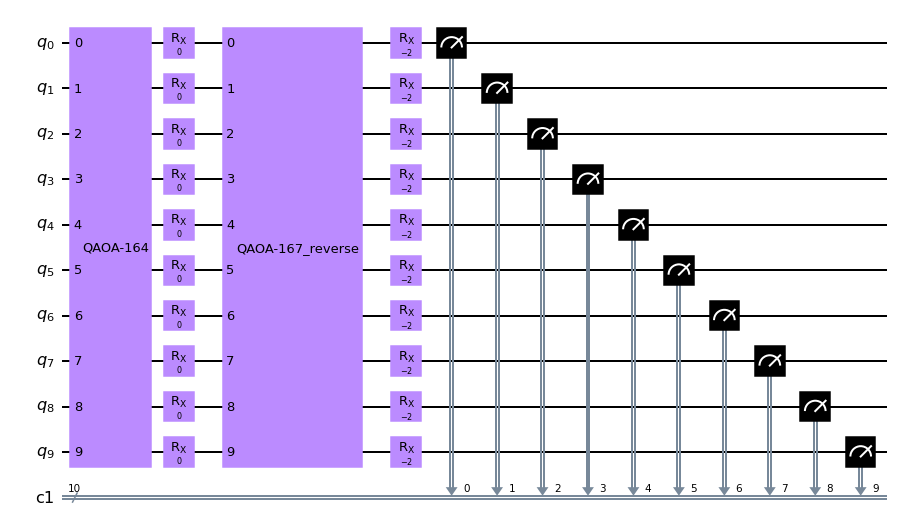

In [15]:
from qopt_best_practices.utils import create_qaoa_swap_circuit, build_paulis
from qiskit.quantum_info import SparsePauliOp

paulis = build_paulis(remapped_g)
theta = [1, 1, 0, 1]
cost_operator = SparsePauliOp.from_list(paulis)
qaoa_circ = create_qaoa_swap_circuit(cost_operator, theta, swap_strategy)
qaoa_circ.draw('mpl')

In [11]:
from qiskit.transpiler.passes import (
    FullAncillaAllocation,
    EnlargeWithAncilla,
    ApplyLayout,
    SetLayout,
)
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    SwapStrategy,
    FindCommutingPauliEvolutions,
    Commuting2qGateRouter,
)

initial_layout = Layout.from_intlist(path, qaoa_circ.qregs[0]) # needs qaoa_circ

backend_cmap = CouplingMap(backend.configuration().coupling_map)
edge_coloring = {(idx, idx + 1): idx % 2 for idx in range(N)}

In [12]:
pm_pre = PassManager(
    [
        # FindCommutingPauliEvolutions(),
        # Commuting2qGateRouter(swap_strategy, edge_coloring),
        SetLayout(initial_layout),
        FullAncillaAllocation(backend_cmap),
        EnlargeWithAncilla(),
        ApplyLayout(),
    ]
)

# Insert swap gates, map to initial_layout and finally enlarge with ancilla.
tcirc = pm_pre.run(qaoa_circ)

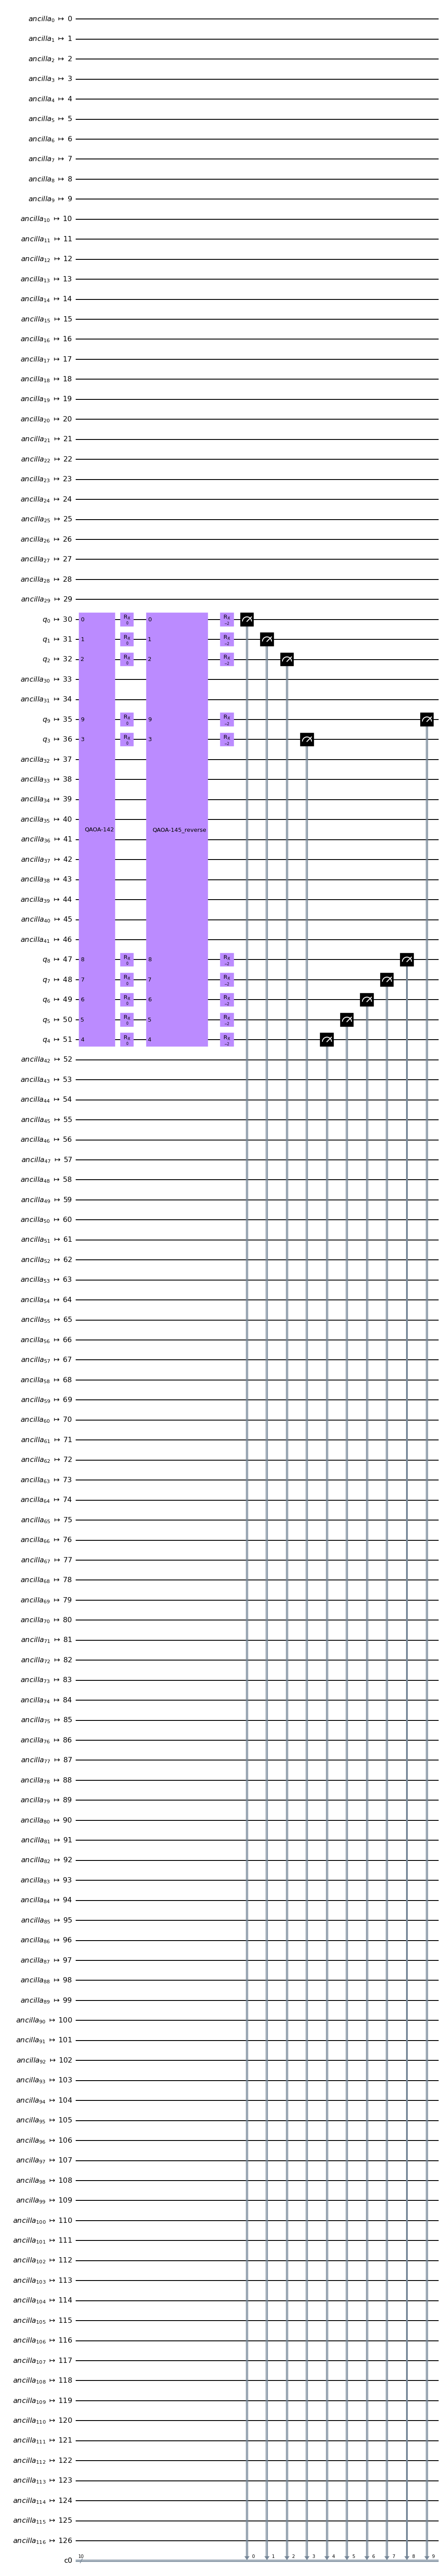

In [13]:
tcirc.draw('mpl')

In [14]:
# First, create the ansatz of 1 layer of QAOA without mixer

from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

operator = SparsePauliOp.from_list(local_correlators)
empty_circ = QuantumCircuit(10)
qaoa_ansatz = QAOAAnsatz(operator,reps=1, initial_state=empty_circ, mixer_operator=empty_circ).decompose()

# This will allow us to recover the permutation of the measurements that the swap introduce.
qaoa_ansatz.measure_all()

qaoa_ansatz.draw('mpl')
# print(qaoa_ansatz.parameters)

NameError: name 'QuantumCircuit' is not defined

In [ ]:
from qiskit import transpile

# Now, apply the swap strategy for commuting pauli evolution gates
pm_pre = PassManager(
    [
        FindCommutingPauliEvolutions(),
        Commuting2qGateRouter(
            swap_strategy,
            edge_coloring,
        )
    ]
)

# apply swaps
qaoa_ansatz = pm_pre.run(qaoa_ansatz)

# basis_gates = ["rz", "sx", "x", "cx"]
#
# # Now transpile to sx, rz, x, cx basis
# qaoa_ansatz = transpile(qaoa_ansatz, basis_gates=basis_gates)
qaoa_ansatz.draw('mpl')

In [ ]:
from qopt_best_practices.utils.circuit_utils import make_meas_map

qaoa_layers = len(theta) // 2
num_qubits = N

# Compute the measurement map (qubit to classical bit).
# we will apply this for qaoa_layers % 2 == 1.
if qaoa_layers % 2 == 1:
    meas_map = make_meas_map(qaoa_ansatz)
else:
    meas_map = {idx: idx for idx in range(num_qubits)}

qaoa_ansatz.remove_final_measurements()
qaoa_ansatz.draw('mpl')

In [ ]:
random_cut = None

gamma = theta[: len(theta) // 2]
beta = theta[len(theta) // 2 :]

circuit = QuantumCircuit(num_qubits)

if random_cut is not None:
    for idx, coin_flip in enumerate(random_cut):
        if coin_flip == 1:
            circuit.x(idx)

for layer in range(qaoa_layers):
    bind_dict = {qaoa_ansatz.parameters[0]: gamma[layer]}
    bound_hc = qaoa_ansatz.assign_parameters(bind_dict)
    if layer % 2 == 0:
        circuit.append(bound_hc, range(num_qubits))
    else:
        circuit.append(bound_hc.reverse_ops(), range(num_qubits))

    circuit.rx(-2 * beta[layer], range(num_qubits))

from qiskit.circuit import ClassicalRegister

creg = ClassicalRegister(num_qubits)
circuit.add_register(creg)

for qidx, cidx in meas_map.items():
    circuit.measure(qidx, cidx)

circuit.decompose()
circuit.draw('mpl')


In [ ]:
# Now, apply the final transpilation steps

pm_pre = PassManager(
    [
        SetLayout(initial_layout),
        FullAncillaAllocation(backend_cmap),
        EnlargeWithAncilla(),
        ApplyLayout(),
    ]
)

# apply swaps
circuit = pm_pre.run(circuit)
circuit.draw('mpl')

In [ ]:
basis_gates = ["rz", "sx", "x", "cx"]
#
# Now transpile to sx, rz, x, cx basis
circuit = transpile(circuit, basis_gates=basis_gates)
circuit.draw('mpl')